In [1]:
import pandas as pd
import numpy as np
import psycopg2

db_navn = 'AC Horsens'
db_brugernavn = 'postgres'
db_adgangskode = 'ACHorsens'
db_host = 'localhost'
conn = psycopg2.connect(
    dbname=db_navn,
    user=db_brugernavn,
    password=db_adgangskode,
    host=db_host
)

cur = conn.cursor()
cur.execute("SELECT schema_name FROM information_schema.schemata")
schemas = cur.fetchall()
print('connected to database')
def map_to_unified_columns_possession(df):
    # Create a dictionary mapping the original column names to the unified column names
    column_mapping = {
        'contestantId': 'contestantId',
        'team_name': 'team_name',
        'id': 'id',
        'eventId': 'eventId',
        'typeId': 'typeId',
        'periodId': 'periodId',
        'timeMin': 'timeMin',
        'timeSec': 'timeSec',
        'outcome': 'outcome',
        'x': 'x',
        'y': 'y',
        'timeStamp': 'timeStamp',
        'lastModified': 'lastModified',
        'playerId': 'playerId',
        'playerName': 'playerName',
        'sequenceId': 'sequenceId',
        'possessionId': 'possessionId',
        'keyPass': 'keyPass',
        'assist': 'assist',
        '140.0': '140.0',
        '141.0': '141.0',
        '318.0': '318.0',
        '321.0': '321.0',
        '210.0': '210',
        '22.0': '22.0',
        '23.0': '23.0',
        '5.0' : '5.0',
        '6.0' : '6.0',
        '9.0' : '9.0',
        '24.0': '24.0',
        '25.0': '25.0',
        '26.0': '26.0',
        '107.0':'107.0',
        '210.0':'210.0',
        '213.0':'213.0',
        'match_id': 'match_id',
        'label': 'label',
        'date': 'date',
    }
    for col in column_mapping.values():
        if col not in df.columns:
            df[col] = None

    # Rename columns using the mapping dictionary
    unified_df = df.rename(columns=column_mapping)

    return unified_df

def fetch_and_save_possession_data_for_nordic_bet_teams():
    try:
        conn = psycopg2.connect(
            dbname=db_navn,
            user=db_brugernavn,
            password=db_adgangskode,
            host=db_host,
            port="5432"
        )
        cur = conn.cursor()

        cur.execute('SELECT table_name FROM information_schema.tables WHERE table_schema = %s', ('DNK_1_Division_2024_2025',))
        tables = cur.fetchall()

        relevant_tables = [table[0] for table in tables if table[0] and 'possession_data' in table[0]]

        all_data_frames = []
        for table_name in relevant_tables:
            cur.execute(f'SELECT * FROM "DNK_1_Division_2024_2025"."{table_name}"')
            data = cur.fetchall()
            column_names = [desc[0] for desc in cur.description]

            # Create a DataFrame with the fetched data
            df = pd.DataFrame(data, columns=column_names)

            # Map data to the correct columns in the unified DataFrame
            unified_df = map_to_unified_columns_possession(df)

            all_data_frames.append(unified_df)

        # Concatenate all DataFrames into one
        combined_df = pd.concat(all_data_frames, ignore_index=True)
    
    except Exception as e:
        print(f"Error fetching and saving data for : {e}")
    finally:
        if 'cur' in locals() and cur is not None:
            cur.close()
        if 'conn' in locals() and conn is not None:
            conn.close()
    return combined_df

df = fetch_and_save_possession_data_for_nordic_bet_teams()

connected to database


20405
483


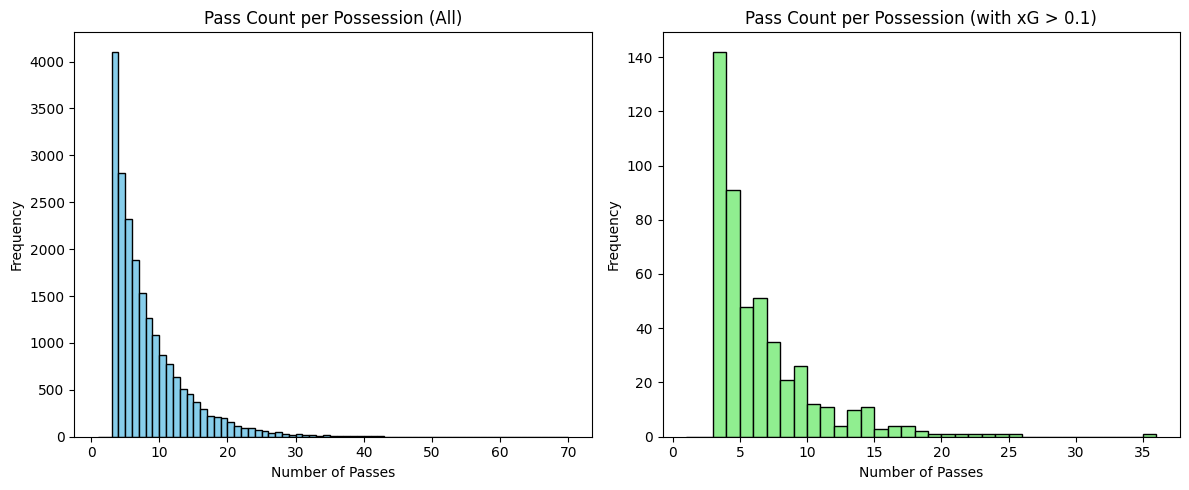

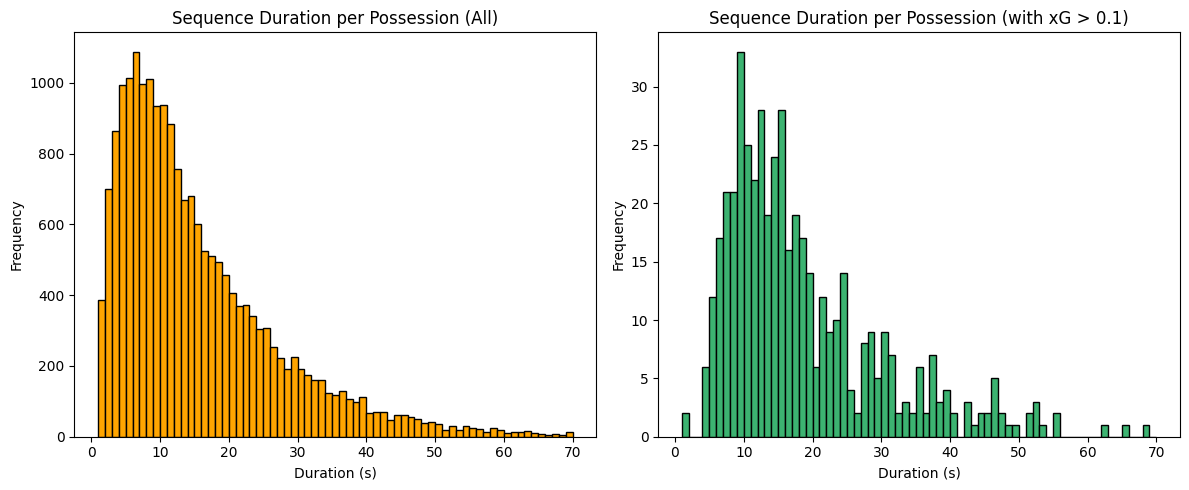

Pass Count (All): 80% between 3.0 and 15.0
Pass Count (xG > 0.1): 80% between 3.0 and 11.0
Sequence Duration (All): 80% between 3.60 and 31.77 seconds
Sequence Duration (xG > 0.1): 80% between 7.00 and 36.80 seconds


In [2]:
df_passes = df[df['typeId'] == '1']
df_passes = df_passes[['team_name','label','date','possessionId','typeId','sequence_duration','sequence_xG']]
df_passes['sequence_xG'] = df_passes['sequence_xG'].astype(float)
df_passes['sequence_duration'] = df_passes['sequence_duration'].astype(float)
df_passes_with_xg = df_passes[df_passes['sequence_xG']>0.1]
df_pass_counts = (
    df_passes
    .groupby(['team_name', 'label', 'date', 'possessionId'])
    .size()
    .reset_index(name='pass_count')
)
df_pass_counts = df_pass_counts[df_pass_counts['pass_count'] >2]
print(len(df_pass_counts))

df_pass_counts_with_xg = (
    df_passes_with_xg
    .groupby(['team_name', 'label', 'date', 'possessionId'])
    .size()
    .reset_index(name='pass_count')
)
df_pass_counts_with_xg = df_pass_counts_with_xg[df_pass_counts_with_xg['pass_count'] >2]
print(len(df_pass_counts_with_xg))

import matplotlib.pyplot as plt

# Histogram for all possessions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_pass_counts['pass_count'], bins = range(1, df_pass_counts['pass_count'].max() + 2)
, color='skyblue', edgecolor='black')
plt.title('Pass Count per Possession (All)')
plt.xlabel('Number of Passes')
plt.ylabel('Frequency')

# Histogram for possessions with xG
plt.subplot(1, 2, 2)
plt.hist(df_pass_counts_with_xg['pass_count'], bins = range(1, df_pass_counts_with_xg['pass_count'].max() + 2)
, color='lightgreen', edgecolor='black')
plt.title('Pass Count per Possession (with xG > 0.1)')
plt.xlabel('Number of Passes')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

df_duration = (
    df_passes
    .groupby(['team_name', 'label', 'date', 'possessionId'])['sequence_duration']
    .mean()  # or use .sum() if you prefer total duration
    .reset_index()
)
df_duration = df_duration.merge(df_pass_counts[['team_name', 'label', 'date', 'possessionId', 'pass_count']],
                                on=['team_name', 'label', 'date', 'possessionId'])

# Filter out possessions with <= 2 passes
df_duration = df_duration[df_duration['pass_count'] > 2]

# Same for possessions with xG > 0.1
df_duration_with_xg = (
    df_passes_with_xg
    .groupby(['team_name', 'label', 'date', 'possessionId'])['sequence_duration']
    .mean()
    .reset_index()
)
df_duration_with_xg = df_duration_with_xg.merge(df_pass_counts_with_xg[['team_name', 'label', 'date', 'possessionId', 'pass_count']],
                                                on=['team_name', 'label', 'date', 'possessionId'])
df_duration_with_xg = df_duration_with_xg[df_duration_with_xg['pass_count'] > 2]

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_duration['sequence_duration'], bins = range(1, df_pass_counts['pass_count'].max() + 2), color='orange', edgecolor='black')
plt.title('Sequence Duration per Possession (All)')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_duration_with_xg['sequence_duration'], bins = range(1, df_pass_counts['pass_count'].max() + 2), color='mediumseagreen', edgecolor='black')
plt.title('Sequence Duration per Possession (with xG > 0.1)')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# --- PASS COUNTS ---
p_low_all = df_pass_counts['pass_count'].quantile(0.10)
p_high_all = df_pass_counts['pass_count'].quantile(0.90)
print(f"Pass Count (All): 80% between {p_low_all:.1f} and {p_high_all:.1f}")

p_low_xg = df_pass_counts_with_xg['pass_count'].quantile(0.10)
p_high_xg = df_pass_counts_with_xg['pass_count'].quantile(0.90)
print(f"Pass Count (xG > 0.1): 80% between {p_low_xg:.1f} and {p_high_xg:.1f}")

# --- SEQUENCE DURATION ---
d_low_all = df_duration['sequence_duration'].quantile(0.10)
d_high_all = df_duration['sequence_duration'].quantile(0.90)
print(f"Sequence Duration (All): 80% between {d_low_all:.2f} and {d_high_all:.2f} seconds")

d_low_xg = df_duration_with_xg['sequence_duration'].quantile(0.10)
d_high_xg = df_duration_with_xg['sequence_duration'].quantile(0.90)
print(f"Sequence Duration (xG > 0.1): 80% between {d_low_xg:.2f} and {d_high_xg:.2f} seconds")
